# Split-admixture model

As in [Skoglund et al., 2014](https://academic.oup.com/mbe/article/31/9/2516/2925787):
- populations A and B diverged 8000 years ago
- admixture between A and B 3000 years b.p., where 75% of the genetic material of the modern population was contributed by population A and 25% by population B
- 20 modern individuals sampled in population A
- 20 ancient samples taken between 500 and 10000 years ago, spread out evenly by 500 years
- 4 ancient samples 3500, 4500, 5500 and 6500 years b.p. in population B
- the remaining 16 ancient individuals sampled in population A

In [1]:
import msprime
import allel
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def modernSamples(n, deme):
    """
    n = number of modern samples (haploids)
    deme = the number of the deme the samples belong to
    """
    samples = []
    for i in range(0,n):
        samples.append(msprime.Sample(deme,0))
    return(samples)


def ancientSamples(nb, age, deme):
    """
    nb = number of ancient samples (haploids)
    age = age of the samples, in generations
    deme = the number of the deme the samples belong to
    """
    samples = []
    for i in range(0,nb):
        samples.append(msprime.Sample(deme, age))
    return(samples)

def createSamples(nbA, ages, deme):
    """
    nbM = number of modern samples (diploids)
    nbA = number of ancient samples (diploids)
    age = list of past generations for ancient samples
    """
    samples = []
    for i in ages:
        samples += ancientSamples(2*nbA, i, deme)
    return samples

In [3]:
def run_sim(num_replicates, nbA, nbM, l, samples, population_configurations, demographic_events):
    """
    Runs num_replicates simulations, each one generating a very small number of SNPs. All these mutations are
    pooled in order get thousands of independent SNPs.
    """
    s = 0
    replicates = msprime.simulate(length= 2, samples = samples,
                                  mutation_rate=5e-6, recombination_rate=1e-8,
                                  num_replicates=num_replicates,
                                  population_configurations = population_configurations,
                                  demographic_events = demographic_events)
    for j, ts in enumerate(replicates):
        h = np.zeros((ts.get_num_mutations(), int(ts.get_sample_size()/2), 2),
             dtype=np.int8)
        for variant in ts.variants():
            h[variant.index] = np.reshape(variant.genotypes , (nbM+nbA*l,2))
        if s==0:
            haplotypes = h
        else:
            haplotypes = np.concatenate((haplotypes, h), axis=0)
        s += ts.get_num_mutations()
    return(haplotypes)

In [4]:
def plot_pca_coords(coords, model, pc1, pc2, ax, ages, nbM, nbA):
    i = 0
    # modern samples
    x = coords[0:nbM, pc1]
    y = coords[0:nbM, pc2]
    ax.plot(x, y, marker='o', linestyle=' ', label='modern', color=type_color['modern'], markersize=6, mec='k', mew=.5)
    i += nbM
    # ancient samples
    for a in ages:
        x = coords[i:i+nbA, pc1]
        y = coords[i:i+nbA, pc2]
        ax.plot(x, y, marker='o', linestyle=' ', label=str(a),
                color=type_color[str(a)], markersize=6, mec='k', mew=.5)
        i += nbA
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))

In [5]:
def plot_PC_maps(coords, model, pc, ax, ages, nbM, nbA, admixture_time, split_time):
    """
    Plots each PC element against the sample number.
    """
    sns.despine(ax=ax, offset=5)
    # modern samples
    y = coords[0:nbM, pc]
    x = np.zeros(len(y))
    ax.plot(x, y, marker='o', linestyle=' ', label='modern', color=type_color['modern'], markersize=6, mec='k', mew=.5)
    i = nbM
    # ancient samples
    for a in ages:
        y = coords[i:i+nbA, pc]
        x = np.ones(len(y))
        ax.plot(x*a*25, y, marker='o', linestyle=' ', label=a, color=type_color[str(a)], markersize=6, mec='k', mew=.5)
        i += nbA
    ax.set_ylabel('PC%s (%.1f%%)' % (pc+1, model.explained_variance_ratio_[pc]*100))
    ax.set_xlabel('Age (years b.p.)')
    ax.axvline(admixture_time*25, linestyle=':', color="black", label="admixture")
    ax.axvline(split_time*25, linestyle='--', color="black", label="split")

In [6]:
Ne = 5000
nbM = 20
nbA = 1

ages0 = [20,40,60,80,100,120,160,200, 240, 280, 300, 320, 340, 360, 380, 400]
ages1 = [140, 180, 220, 260]
samples = [msprime.Sample(0,0) for i in np.arange(2*nbM)] 
samples += createSamples(nbA, ages0, 0) 
samples += createSamples(nbA, ages1, 1)

split_time = 320
admixture_time = 120

population_configurations = [
    msprime.PopulationConfiguration(initial_size=Ne),
    msprime.PopulationConfiguration(initial_size=Ne)]
demographic_events=[
    msprime.MassMigration(admixture_time, source=0, dest=1, proportion=0.25),
    msprime.MassMigration(split_time, source=1, dest=0)]

dp = msprime.DemographyDebugger(           
    population_configurations=population_configurations,
    demographic_events=demographic_events)
dp.print_history()

Epoch: 0 -- 120.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  5e+03    5e+03               0 |     0        0    
1 |  5e+03    5e+03               0 |     0        0    

Events @ generation 120.0
   - Mass migration: lineages move from 0 to 1 with probability 0.25
Epoch: 120.0 -- 320.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  5e+03    5e+03               0 |     0        0    
1 |  5e+03    5e+03               0 |     0        0    

Events @ generation 320.0
   - Mass migration: lineages move from 1 to 0 with probability 1.0
Epoch: 320.0 -- inf generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  5e+03    5e+03               0 |     0        0    
1 |  5e+03    5e+03               0 |     0        0    



In [7]:
g = allel.model.GenotypeArray(run_sim(100000, nbA, nbM, len(ages0)+len(ages1), samples, 
                                      population_configurations, demographic_events))
g

<GenotypeArray shape=(107101, 40, 2) dtype=int8>
0/0 0/0 0/0 1/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
1/0 0/0 0/1 0/0 1/0 ... 1/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
...
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 1/0 0/0 1/0 1/0 0/0
1/1 0/1 1/1 1/1 1/1 ... 0/0 1/1 1/1 1/1 1/0

In [8]:
gn = g.to_n_alt()[:]

# PCA
coords, model = allel.stats.pca(gn, scaler=None)
coords2, model2 = allel.stats.pca(gn)

In [9]:
times = ['modern'] + list(map(str, ages0)) + list(map(str, ages1))
palette = sns.color_palette("hls", len(times))
i = 0
type_color = {}
for t in times:
    type_color[t] = palette[i]
    i += 1

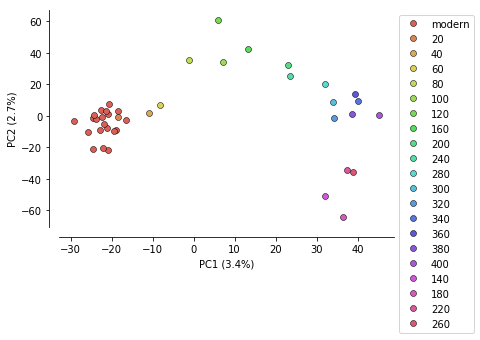

In [10]:
fig, ax = plt.subplots()
sns.despine(ax=ax, offset=10)
plot_pca_coords(coords, model, 0, 1, ax, ages0+ages1, nbM, nbA)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')

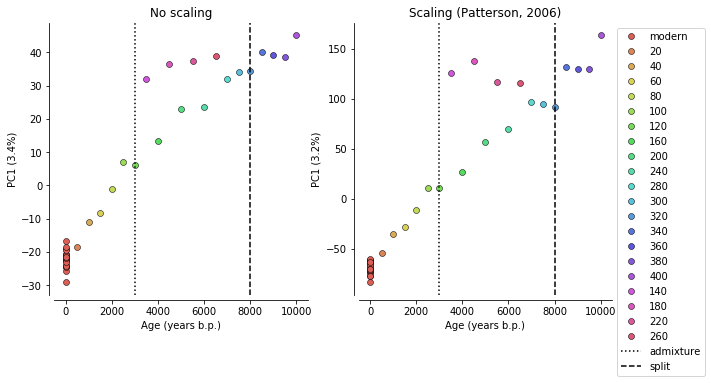

In [11]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
plot_PC_maps(coords, model, 0, ax, ages0+ages1, nbM, nbA, admixture_time, split_time)
ax.set_title("No scaling")
ax = fig.add_subplot(1,2,2)
plot_PC_maps(coords2, model2, 0, ax, ages0+ages1, nbM, nbA, admixture_time, split_time)
ax.set_title("Scaling (Patterson, 2006)")
ax.legend(bbox_to_anchor=(1,1), loc='upper left')

In [12]:
sample_pops = ['pop0'] * (nbM+len(ages0)*nbA) + ['pop1'] * nbA*len(ages1)
sample_times = [0] * nbM + ages0+ages1

# with open("genotype_split_admixture.txt", "w") as f:
#     for ind in np.arange(gn.shape[1]):
#         f.write("%s.%s\t" % (sample_pops[ind], sample_times[ind]))
#         for var in np.arange(gn.shape[0]):
#             if var != gn.shape[0]-1:
#                 f.write("%s\t" % gn[var, ind])
#             else:
#                 f.write("%s\n" % gn[var, ind])

PC1 distinguishes samples from population A and B. The 2 series of individuals become more similar as time approaches the time of admixture.

## Other configuration for this scenario

- pop 0 split into pop 0 and pop 1 320 generations ago
- pop 0 split into pop 0 and pop 2 120 generations ago
- admixture of 25% of pop 1 into pop 2 at the same time, 120 generations ago

In [12]:
Ne = 5000

admixture_time = 120
split_time = 320

population_configurations = [
    msprime.PopulationConfiguration(initial_size = Ne),
    msprime.PopulationConfiguration(initial_size = Ne),
    msprime.PopulationConfiguration(initial_size = Ne)
]
demographic_events = [
    msprime.MassMigration(admixture_time, source=2, dest=1, proportion=0.25), # Admixture de x% de pop1 dans pop2
    msprime.MassMigration(admixture_time, source=2, dest=0, proportion=1), # La pop 0 split en pop 0 et pop 2
    msprime.MassMigration(split_time, source=1, dest=0, proportion=1), # La pop 0 split en pop 0 et pop 1
]

nbSamples = 1
ages0 = [120, 160, 200, 240, 280, 300, 320, 340, 360, 380, 400]
ages1 = [140, 180, 220, 260]
ages2 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 40, 60, 80, 100]
samples = []
for a in ages0:
    samples += [msprime.Sample(0,a) for i in np.arange(2*nbSamples)]
for a in ages1:
    samples += [msprime.Sample(1,a) for i in np.arange(2*nbSamples)]
for a in ages2:
    samples += [msprime.Sample(2,a) for i in np.arange(2*nbSamples)]
    
def segregating_sites_examples(num_replicates, nbSamples, population_configurations, demographic_events, samples):
    s = 0
    replicates = msprime.simulate(length= 2,
                                  mutation_rate=5e-6, recombination_rate=1e-8,
                                  samples = samples,
                                  num_replicates=num_replicates,
                                  population_configurations = population_configurations,
                                  demographic_events=demographic_events)
    for j, ts in enumerate(replicates):
        h = np.zeros((ts.get_num_mutations(), int(ts.get_sample_size()/2), 2),
             dtype=np.int8)
        for variant in ts.variants():
            h[variant.index] = np.reshape(variant.genotypes , (nbSamples*len(ages0) + nbSamples*len(ages1) + nbSamples*len(ages2),2))
        if s==0:
            haplotypes = h
        else:
            haplotypes = np.concatenate((haplotypes, h), axis=0)
        s += ts.get_num_mutations()
    return(haplotypes)

g = allel.model.GenotypeArray(segregating_sites_examples(100000, nbSamples, population_configurations,
                                                         demographic_events, samples))
g

<GenotypeArray shape=(107013, 40, 2) dtype=int8>
0/1 0/0 1/0 0/0 1/0 ... 0/1 0/1 0/0 0/1 0/1
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
...
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/0 0/0 0/0 1/0 1/0 ... 0/0 1/0 0/0 0/0 0/0
0/0 0/0 0/0 0/1 0/0 ... 0/0 0/0 0/0 0/0 0/0

In [13]:
gn = g.to_n_alt()[:]

# PCA
coords, model = allel.stats.pca(gn, scaler=None)
coords.shape

palette0 = sns.color_palette("Reds_r", len(ages0))
palette1 = sns.color_palette("Blues_r", len(ages1))
palette2 = sns.color_palette("Purples_r", len(ages2))

colors = {}
pops = []
sample_pops = []
sample_times = []
i = 0
for a in ages0:
    name = "pop0, " + str(a)
    pops.append(name)
    colors[name] = palette0[i]
    sample_times.append(a)
    sample_pops.append('pop0')
    i += 1
i = 0
for a in ages1:
    name = "pop1, " + str(a)
    pops.append(name)
    colors[name] = palette1[i]
    sample_times.append(a)
    sample_pops.append('pop1')
    i += 1
i = 0
for a in np.unique(ages2):
    name = "pop2, " + str(a)
    pops.append(name)
    colors[name] = palette2[i]
    sample_times.append(a)
    sample_pops.append('pop2')
    if a == 0:
        for j in np.arange(19):
            sample_times.append(a)
            sample_pops.append('pop2')
    i += 1
    
    
# with open("genotype_skoglund_split_adm.txt", "w") as f:
#     i = 0
#     for ind in np.arange(gn.shape[1]):
#         f.write("%s\t%s\t" % (sample_pops[ind], sample_times[ind]))
#         for var in np.arange(gn.shape[0]):
#             if var != gn.shape[0]-1:
#                 f.write("%s\t" % gn[var, ind])
#             else:
#                 f.write("%s\n" % gn[var, ind])
#         i += 1

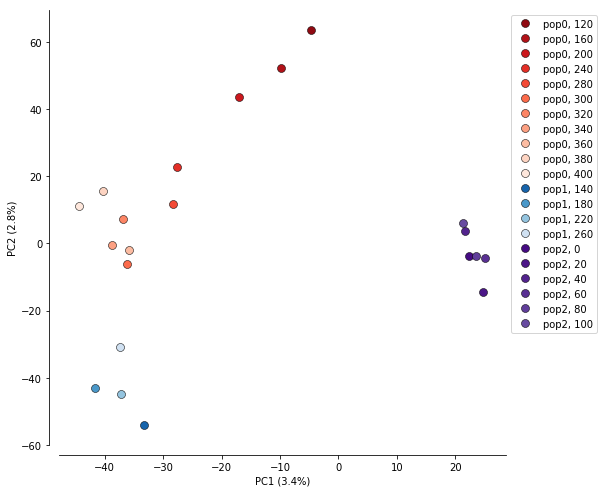

In [14]:
def plot_pca_coords(coords, model, pc1, pc2, ax):
    i = 0
    for pop in pops:
        x = coords[i:i+nbSamples, pc1]
        y = coords[i:i+nbSamples, pc2]
        ax.plot(x, y, marker='o', linestyle=' ', label=pop, color=colors[pop], markersize=8, mec='k', mew=.5)
        i += nbSamples
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))
    
fig, ax = plt.subplots(figsize=(8,8))
sns.despine(ax=ax, offset=10)
plot_pca_coords(coords, model, 0, 1, ax)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')

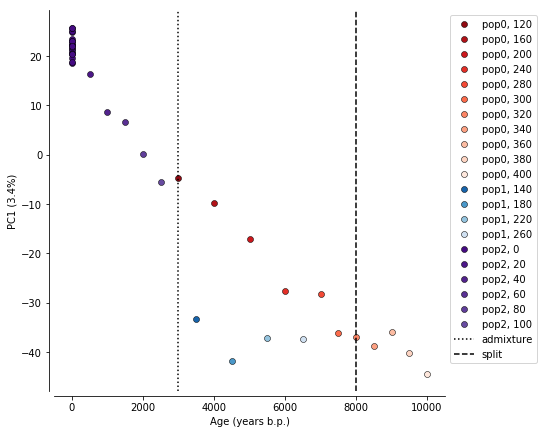

In [15]:
def plot_PC_maps(coords, model, pc, ax):
    """
    Plots each PC element against the sample number.
    """
    sns.despine(ax=ax, offset=5)
    i = 0
    for a in ages0:
        y = coords[i:i+nbSamples, pc]
        x = np.ones(len(y))
        name = "pop0, " + str(a)
        ax.plot(x*a*25, y, marker='o', linestyle=' ', label=name, color=colors[name], markersize=6, mec='k', mew=.5)
        i += nbSamples
    for a in ages1:
        y = coords[i:i+nbSamples, pc]
        x = np.ones(len(y))
        name = "pop1, " + str(a)
        ax.plot(x*a*25, y, marker='o', linestyle=' ', label=name, color=colors[name], markersize=6, mec='k', mew=.5)
        i += nbSamples
    done  = False
    for a in ages2:
        y = coords[i:i+nbSamples, pc]
        x = np.ones(len(y))
        name = "pop2, " + str(a)
        if (not done and a == 0) or (done and a != 0):
            ax.plot(x*a*25, y, marker='o', linestyle=' ', label=name, color=colors[name], markersize=6, mec='k', mew=.5)
        else:
            ax.plot(x*a*25, y, marker='o', linestyle=' ', color=colors[name], markersize=6, mec='k', mew=.5)
        done = True
        i += nbSamples
    ax.set_ylabel('PC%s (%.1f%%)' % (pc+1, model.explained_variance_ratio_[pc]*100))
    ax.set_xlabel('Age (years b.p.)')
    ax.axvline(admixture_time*25, linestyle=':', color="black", label="admixture")
    ax.axvline(split_time*25, linestyle='--', color="black", label="split")

    
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1)
plot_PC_maps(coords, model, 0, ax)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
